# Homework 1 (Total Points: 175)



Learning Goals:
- Learn how to load a dataset and process it.
- Learn how to implement several IR methods (TFIDF, BM25, QL) and understand their weaknesses & strengths.
- Learn how to evaluate IR methods


**NOTE 1**: Only the code (`TODO: Implement this!` denotes these sections) is graded. The 'theory' questions in this assignment serve as a preparation for the exam and to facilitate a deeper understanding of the course content. These questions (denoted by `TODO: Answer this!`) have no points assigned to them, but **need** to be filled out before submission.  

**NOTE 2**: You can use the `nltk`, `numpy` and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. 

**NOTE 3**: The notebook you submit has to have the student ids, seperated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 

**NOTE 4**: Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  

---
Additional Resources: 
-  Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)


In [1]:
# !pip3 install nltk
# !pip3 install tqdm

In [2]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.html import widgets
from collections import namedtuple
from collections import Counter
from pprint import pprint

%matplotlib inline

F:\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Section 1: Text Processing (20 points)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 

The following cell downloads the dataset and unzips it to a local directory

In [3]:
def download_dataset(folder_path = "./datasets/"):
    
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

You can see a brief description of each file in the dataset by looking at the README file

In [4]:
##### Read the README file 
!cat ./datasets/README
#####

'cat' is not recognized as an internal or external command,
operable program or batch file.


----
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available. 
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [5]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
!head -45 ./datasets/cacm.all
#####

'head' is not recognized as an internal or external command,
operable program or batch file.


---

Now, write a function to read in the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document

In [6]:
# TODO: Implement this! (4 points)
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/cacm" be default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (seperated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    
    file = root_folder + 'cacm.all'
    cacm_list = []
    with open(file, 'r') as f:
        doc_string = f.read()
        documents = doc_string.split('.I ')
        
        for doc in documents[1:]:
            
            doc = doc.split('\n')
            doc_id = int(doc[0])
            
            for i, line in enumerate(doc):
                
                if line == '.T':
                    title_start = i + 1
                if line == '.W':
                    abstract_start = i + 1
                if line == '.B':
                    abstract_end = i
                    
            try:
                abstract = ' '.join(doc[abstract_start:abstract_end])
                title = ' '.join(doc[title_start:abstract_start-1])
                title_abstract = title + '\n' + abstract
                
            except:
                title = ' '.join(doc[title_start:abstract_end])
                title_abstract = title
            
            cacm_list.append((doc_id, title_abstract))
                
            abstract_start = None
            abstract_end = None
            abstract = None
                
    return cacm_list

docs = read_cacm_docs()
# pprint(docs[:100])

In [7]:
##### 
assert len(docs) == 3204, "There should be exactly 3024 documents"
##### 

---

Next, let us read the queries. They are formatted similarly: 

In [8]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
# 3. the '.W' field (the abstract, which may be absent)
!head -15 ./datasets/query.text
#####

'head' is not recognized as an internal or external command,
operable program or batch file.


---

Now, write a function to read in this file:

In [9]:
# TODO: Implement this! (3 points)
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" be default
        Returns: A list of 2-tuples: (query_id, query)
    """
    
    file = root_folder + 'query.text'
    queries_list = []
    with open(file, 'r') as f:
        doc_string = f.read()
        documents = doc_string.split('.I ')
        documents = [doc for doc in documents if doc != '']
    
        for doc in documents:
            doc = doc.split('\n')
            query_id = int(doc[0])
        
            query_start = None
            query_end = None
            
            for i, line in enumerate(doc):
                
                if line == '.W':
                    query_start = i + 1
                if line == '.A' or line == '.N':
                    if query_end == None:
                        query_end = i
                        
            query = ' '.join(doc[query_start:query_end])
                
            queries_list.append((query_id, query))
    
    return queries_list
                
queries = read_queries()
# pprint(queries)

In [10]:
##### 
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"
##### 

---

Read in the stop words:

In [11]:
!head ./datasets/common_words

'head' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
# TODO: Implement this! (3 points)
def load_stopwords(root_folder = "./datasets/"):
    """
    Load the stopwords
    Output: A set of stopwords
    """
    
    file = root_folder + 'common_words'
    
    with open(file, 'r') as f:
        lines = f.readlines()
        lines_stripped = [line.strip() for line in lines]
        stopwords_set = set(lines_stripped)
    
    return stopwords_set

stopwords = load_stopwords()
assert len(stopwords) == 428

--- 

We can now write some basic text processing functions. A first step is to tokenize the text. You may use any tokenizer available in the `nltk` library:

In [13]:
# TODO: Implement this! (5 points)
def tokenize(text):
    """
        Tokenize the text. 
        Input: text - a string
        Output: a list of tokens
    """
    
    return nltk.word_tokenize(text)

In [14]:
#####
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)
print(tokens)
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---

### *Answer the following questions*: 
- Why is stemming necessary, in particular for IR?
    
    **Answer**: Stemming reduces words to their root form by removing derivational and inflectional affixes. It is important to stem words in IR because it increases the chance of finding relevant documents with a given query. For example, if the query contains the word “programming”, any document that contains words like “programmers”, “programming” and “programs” could be useful. Therefore, by stemming the words in the query and the documents, it improves the performance of the IR program. Furthermore, stemming also reduces the size of the document index because all the derivations of a word can be reduced to one stem, which increases time and memory efficiency.


- Is there any setting (domain, scenario, etc) in which stemming can hurt performance? Illustrate with an example
    
    **Answer**: Stemming can suffer from two issues: overstemming and understemming. Overstemming happens when too much of a word is cut off. This could lead to two or more words being stemmed to the same root that have a different meaning. For example, when the words “university”, “universal”, “universities”, and “universe” are stemmed to “univers”, it could hurt the performance of the IR program, because university/universities don’t have the same meaning as universe/universal. Understemming happens when words that have the same stem are not resolved to the same stem. For example, when “datum” is stemmed to “datu” and “data” to “dat”. Data is the plural form of datum, so should be stemmed to the same root. However, other words like “date” would also be stemmed to “dat”, which complicates the matter. Stemming is merely based on heuristics and is therefore far from perfect. These examples illustrate how stemming can hurt the performance of an IR program when words are overstemmed or understemmed.

Write a function to stem tokens. Again, you can use the `nltk` library for this

In [15]:
# TODO: Implement this! (5 points)
def stem_token(token):
    """
        Stem the given token, using any stemmer available from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    stemmer = nltk.SnowballStemmer("english")
    return stemmer.stem(token)

In [16]:
####
print([stem_token(t) for t in tokens])
tokens_ = [
    'caresses', 'flies', 'dies', 'mules', 'denied',
    'died', 'agreed', 'owned', 'humbled', 'sized',
    'meeting', 'stating', 'siezing', 'itemization',
    'sensational', 'traditional', 'reference', 'colonizer',
    'plotted']
print([stem_token(t) for t in tokens_])
####

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']
['caress', 'fli', 'die', 'mule', 'deni', 'die', 'agre', 'own', 'humbl', 'size', 'meet', 'state', 'siez', 'item', 'sensat', 'tradit', 'refer', 'colon', 'plot']


---

### *Answer the following questions*: 
- Another processing step (not done here) is to use n-grams. Illustrate why you would want to use n-grams in IR with an example.  
    - **Answer**: N-grams are a sequence of N words and they can help with the relations between words both in semantic roles and in meaning of the word through the use of the context. For example a word like book can be a verb as in “to book a flight” or a noun as in “this is a great book”. N grams can help the computer with the understanding of the difference between these two through the use of the context.
- Usage of n-grams exacerbates some problems ex. in bi-gram language models. What is this problem? Suggest one solution 
    - **Answer**: There is a bias-variance trade-off when choosing a value for N in an N-gram model. When the bias is lower in parameter estimation, it can cause the model to have a higher variance of the parameter estimates across samples, and vice versa. High bias can cause the model to miss relevant relations between features and target outputs, also called underfitting. High variance can cause an algorithm to fit random noise in the model, also called overfitting. For large training corpora, it is better to use tri-gram models instead of bi-gram models to prevent from getting a high bias (underfitting).

--- 

The following function puts it all together. Given a string, it tokenizes it, and processes it according to the flags that you set.

In [17]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

Let's create two sets of pre-processed documents

In [18]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text: stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 


We can now process the documents and queries according to the configuration specified above

In [19]:
####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))

# print(doc_repr_1)
# print(doc_repr_2)

####


--- 

## Section 2: Indexing (10 points)

### Building an index

A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  

---

In this assignment we will be using an index created in memory, since our dataset is tiny. To get started, build a simple index that maps simply counts the number of tokens present in a document. This index  is built using a python dictionary.

### *Answer the following questions*:
- What is the time complexity of retrieving a list of documents from a python `dict` object? 
    - **Answer:** Retrieving a list from a python dict takes constant time $\theta$(1)  because it uses keys to retrieve values. 
- Consider the case with a 10 million documents. What is the time complexity of retrieval with an inverted index (assuming you can fit the entire index in memory)? (Hint: Consider length of a query $|q|$) 
    - **Answer:** The time complexity for searching the inverted index is 1 * the length of the query since searching a dict has a constant time of 1. For a search on document vectors this would be m*n where m is the length of the longest document and n is the total number of documents. This is why inverted indexes are prefered even though they take longer to construct. 
- For a large enough collection, we cannot store an index in memory. How is this tackled in practice (briefly explain)? Comment on the time complexity. 
    - **Answer**: One of the ways of dealing with this problem is called the two-pass index method. In this method first all the term statistics are collected and an empty template of the index is created on the disk, then this template is filled in. The problem with this method however is that the whole collection is passed two times and the method therefore takes more time.
- Mention a use-case in which a simple index (from word -> doc_id) might not suffice anymore. How would you modify the index to suit this use-case (if you can!)  
    - **Answer**: In the case of a positional language model, a simple index would not suffice anymore because the position of the words need to be stored along with the words themselves. You could modify the index by creating vectors where the position of the words relates to their indexes in the list.
    
Now, implement a function to build an index:

In [20]:
# TODO: Implement this! 10 points
def build_tf_index(documents):
    """
    Build an inverted index (with counts). The output is a dictionary which takes in a token
    and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
    Input: a list of documents - (doc_id, tokens) 
    Output: An inverted index. [token] -> [(doc_id, token_count)]
    """
    
    invert_index = Counter()
    
    for doc in documents:
        doc_id = doc[0]
        tokens = doc[1]
        
        for token in tokens:
            token_count = (doc_id, tokens.count(token))
            
            if token in invert_index:
                if token_count not in invert_index[token]:
                    invert_index[token].append(token_count)
                    
            else:
                invert_index[token] = [token_count]
    
    return invert_index
 
# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

# This function returns the correct index 
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

# This function returns the correct doc_repr 
def get_doc_repr(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_repr_1,
        2: doc_repr_2
    }[index_set]

# This function returns a dict: key=doc_id, value=amount of words in doc
def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

# Returns doc_lengths dict for config 1 or 2
def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

# This function correctly pre-processes the text given the index set
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)

--- 

## Section 3: Retrieval  (80 points)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- TF-IDF
- BM25
- Query Likelihood Models

--- 

### Ranking functions


Probably the simplest IR model is the Bag of Words (BOW) model. Implement a function that scores a query against a document using this model.   

Note that you can use either the count of the token or 'binarize' it i.e set the value equal to 1 if the token appears.   


**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

In [21]:
# TODO: Implement this! 10 points
def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note #1: You have to use the `get_index` function created in the previous cells
        Note #2: You can binarize the counts if you wish to
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    # inverted index dict: key=word, value=(doc_id, count)
    invert_index = get_index(index_set)
    
    # process query
    processed_query = preprocess_query(query, index_set)
    
    # make dict with query scores per doc: key=doc_id, value=count of query in doc
    query_scores = {}
    
    for query in processed_query:
        if query in invert_index.keys():
            for tup in invert_index[query]:
                if tup[0] in query_scores:
                    query_scores[tup[0]] += tup[1]
                else:
                    query_scores[tup[0]] = tup[1]
    
    # sort list with query scores in descending order
    bow = sorted([(k, float(v)) for k, v in query_scores.items()], key=lambda tup: tup[1], reverse=True)
    
    return bow  

### *Answer the following questions*: 
- The BOW model is might not be a good choice for use in IR. Why? 
    - **Answer**: The bag of words model assigns equal value to every word in a query, irrespective of their importance. For example, words that are very common like ‘of’, ‘a’ and ‘the’ don’t have as much classifying power as a unique word like ‘electroencephalography’. The search algorithm TF-IDF does take the importance of words into account. Furthermore, due to the enormous amount of words used on the web the vectors in bag of words might become extremely large.

In [22]:
####
docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow = bow_search("report", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow)
#### 

BOW Results:
Rank 0(6.0): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(5.0): An Information Algebra - Phase I Report-Language S...
Rank 2(3.0): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(2.0): Automatic Abstracting and Indexing Survey and Reco...
Rank 4(2.0): A String Language for Symbol Manipulation Based on...


Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

In [23]:
# TODO: Implement this! (5 points)
def compute_df(documents, index_set):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency)
    """
    
    # inverted index dict: key=word, value=(doc_id, count)
    invert_index = get_index(index_set)
    
    # dict of word frequency in all docs: key: word, value: word frequency over all docs
    word_freq = {}
    
    for key in invert_index:
        word_freq[key] = len(invert_index[key])
        
    # list of word frequencies in descending order
    sorted_word_freq = sorted(word_freq, key=lambda k: word_freq[k], reverse=True)
    print('Most common words with config {}:\n'.format(index_set), sorted_word_freq[:50], '\n')
    
    return word_freq



# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1], index_set=1)
df_2 = compute_df([d[1] for d in doc_repr_2], index_set=2)

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]

Most common words with config 1:
 ['of', 'a', 'the', '.', 'and', 'for', 'in', ')', 'is', 'to', '(', ',', 'algorithm', 'are', 'an', 'on', 'this', 'with', 'which', 'by', 'be', 'that', 'as', 'computer', 'it', 'system', 'paper', 'can', 'from', 'described', 'method', 'presented', 'program', ']', '[', 'given', 'data', 'use', 'programming', 'or', 'used', 'these', 'systems', 'number', 'has', 'time', 'language', 'such', 'at', 'been'] 

Most common words with config 2:
 ['.', ')', '(', ',', 'algorithm', 'comput', 'program', 'system', 'present', 'method', 'paper', 'problem', ']', '[', 'data', 'languag', 'discuss', 'number', 'process', 'techniqu', 'time', 'oper', 'function', 'general', 'result', 'requir', 'develop', ':', 'applic', 'design', 'structur', "'s", 'inform', 'set', 'implement', "''", '``', 'procedur', 'generat', 'effici', 'storag', 'solut', 'includ', 'base', 'analysi', 'shown', 'perform', ';', 'relat', 'propos'] 



Next, implement a function that computes a tf-idf score given a query.      

In [24]:
# TODO: Implement this! 10 points
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    # get inverted index: key=word, value=(doc_id, count)
    invert_index = get_index(index_set)
    # get word frequencies: key=word, value=number of docs containing the word
    word_freq = get_df(index_set)
    # process query: [tokenized_query]
    processed_query = preprocess_query(query, index_set)
    # store doc_length in dict: key=doc_id, value=number of words in doc
    doc_lengths = get_doc_lengths(index_set)
    
    # TF: (Frequency of the word in the doc) / (Total number of words in the doc)
    # TF values dict: key=query_token, value=TF
    # TFIDF dict: key=doc_id, value=tfidf_value
    tfidf_values = {}
    for token in processed_query:
        if token in invert_index.keys():
            # IDF: log((Total number of documents)/(Number of documents containing the word))
            # add 1 to numerator and denominator to prevent divisions by 0
            idf_value = np.log(1 + len(doc_lengths)/(1 + word_freq[token]))
            for tup in invert_index[token]:
                doc_id = tup[0]
                tf_value = 1 + np.log(tup[1])     # sublinear TF = 1 + log(term frequency)
                tf_idf = idf_value * tf_value    # TF_IDF = IDF(token) * TF(token, doc_id)
                if doc_id in tfidf_values:
                    tfidf_values[doc_id] += tf_idf    # if len(query) > 1, sum TF-IDF values for every doc_id
                else:
                    tfidf_values[doc_id] = tf_idf
   
    # sort tfidf into list with tuples: (doc_id, tfidf_value)
    tfidf_scores = sorted([(k, v) for k, v in tfidf_values.items()], key=lambda tup: tup[1], reverse=True)
    
    return tfidf_scores

In [25]:
####
test_tfidf = tfidf_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf)
####

TFIDF Results:
Rank 0(1.1e+01): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(1e+01): An Information Algebra - Phase I Report-Language S...
Rank 2(8.3): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(6.7): Automatic Abstracting and Indexing Survey and Reco...
Rank 4(6.7): A String Language for Symbol Manipulation Based on...


### *Answer the following questions*: 
- It is generally not advisable to use the naive version of tf-idf. Why?
    - **Answer**: It is not a good idea to use the naive version of tf-idf because the IDF value (N / df) can explode when the number of documents N is very large and the document frequency (df) is low. That's why it's advisable to take the logarithm of idf: log(N/df). Sometimes 'smoothing' is used on the IDF by adding a 1 to the numerator and denominator to prevent zero divisions: idf(t, d) = log(1 + N/1+ df). Sometimes sublinear scaling is used to compensate for terms that occur frequently in a document: tf(t, d) = 1 + log(tf).
- Illustrate with an example why using a sublinear scaling for TF is preferable in some cases.  
    - **Answer**: Like I said before, sublinear scaling for TF is used to shrink the ratio between high and low occurring words, so it prevents over-weighting of words. This can be used in cases where there are words in a document that occur frequently and get a too high weight.

--- 

### *Answer the following questions*: 
- An alternative way to compute a query<>document score is to vectorize both the query and document (where each dimension corresponds to a token), and compute a score. The score can be computed using a dot product between the query and the document vectors. Why is the cosine similary function a better choice, particularly in IR? 
    - **Answer**: Cosine similarity is prefered over the dot product because it does not take in to account the magnitude of the vectors but only the angle between them. Since in IR the magnitude is not relevant combined with the high dimensionality of the vectors, cosine similarity is prefered
- What is the time complexity of a search if we are using the vector space method mentioned in the previous question? What is the time complexity if we're using an index (assume that it fits in memory)? Assume $N$ is the number of documents and $|q|$ is the length of a query. 
    - **Answer**: When using a vector spaced method the complete vector has to be searched when searching for a word. This results in a very high time complexity, namely |q| (N * M) where |q| is the length of the query, N is the number of documents and M is the length of the longest document. If we are using indexing, the time complexity is simply 1, however the time complexity of building of the index is M * N.

--- 

#### Query Likelihood Models

In this section you will implement a simple query likelihood model. 

First, let use implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 

**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

--- 

### *Answer the following questions*: 
- Write down the formula for computing the query likelihood, assuming a multinomial unigram language model. 
    - **Answer**: Bayes rule gives us P(D|Q) = (P(Q|D) * P(D)) / P(Q), the probability of a query (Q) is the same for all documents so can be left out, leaving us with P(Q|D) * P(D). The probability of a document is usually assumed to be uniform. This results in the formula ending as P(D|Q) = P(Q|D). Where P (Q|D) is the probability of finding the words of the query in the document. This is calculated by taking the product of the occurrences of each word in the query divided by the length of the document. 
∏n i=1 P(qi |D)

- What problem does this naive method have? Suggest a simple way to fix it.
    - **Answer**: The method assumes that every word in the query is also in the documents, however, this is usually not the case. In this method when a word will not be present in the document this will result in a factor 0 in de product, thus resulting in the whole product becoming 0. 

In [26]:
# TODO: Implement this! 15 points
def naive_ql_search(query, index_set):
    prob_list = []
    zero_freq = False
    
    assert index_set in {1, 2}
    if index_set == 1:
        all_lengths = get_doc_lengths(index_set)
        indexes = get_index(index_set)
        processed_query = preprocess_query(query, index_set)
    elif index_set == 2:
        all_lengths = get_doc_lengths(index_set)
        indexes = get_index(index_set)
        processed_query = preprocess_query(query, index_set)
    
    for word in processed_query:
        if word in indexes:
            word_indexes = indexes[word]
        else:
            zero_freq = True
#             print( 'All docs are 0 for this query')
            break
            
        docs = [index[0] for index in word_indexes]
#         print(docs)
        occurrences = [index[1] for index in word_indexes]
        lengths = [all_lengths[doc] for doc in docs]
        prob_word = [occurrences[i]/lengths[i] for i in range(0,len(occurrences))]
        
        doc_dict = {}
        for i in range(0,len(docs)):
            if docs[i] not in doc_dict:
                doc_dict[docs[i]] = prob_word[i]
            else:
                doc_dict[docs[i]] *= prob_word[i]
    
    if not zero_freq:
        for key, value in doc_dict.items():
            prob_tuple = (key, value)
            prob_list.append(prob_tuple)
    prob_list.sort(key=lambda tup: tup[1], reverse=True)
#     print(prob_list)
    return prob_list

# query = 'algebraic'
# x = naive_ql_search(query, 2)
# print(x)

In [27]:
####
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_naiveql)
####

TFIDF Results:
Rank 0(0.2): ALGOL Sub-Committee Report - Extensions...
Rank 1(0.2): A Report Writer For COBOL...
Rank 2(0.2): A CRT Report Generating System...
Rank 3(0.17): Supplement to the ALGOL 60 Report...
Rank 4(0.14): Report on the Algorithmic Language FORTRAN II...


Now, let's implement a (slightly more) complex QL model. This model should 'fix' the issue with the previous method. If your model requires hyperparameters, set a reasonable value. 

In [28]:
# TODO: Implement this! 15 points
def ql_search(query, index_set):
    prob_list = []
    
    all_lengths = get_doc_lengths(index_set)
    indexes = get_index(index_set)
    processed_query = preprocess_query(query, index_set)
    
    for word in processed_query:
        zero_freq = False
        
        if word in indexes:
            word_indexes = indexes[word]
            docs = [index[0] for index in word_indexes]
            occurrences = [index[1] for index in word_indexes]
            lengths = [all_lengths[doc] for doc in docs]
            prob_word = [(occurrences[i] + ALPHA) / (lengths[i] + (len(processed_query) * ALPHA)) 
                         for i in range(0,len(occurrences))]
        else:
            zero_freq = True
            docs = [index for index in range(1,3205)]
            lengths = [all_lengths[doc] for doc in docs]
            prob_word = [(0 + ALPHA) / (lengths[i] + (len(processed_query) * ALPHA)) for i in range(0,3204)]
        
        doc_dict = {}
        for i in range(0,len(docs)):
            if docs[i] not in doc_dict:
                doc_dict[docs[i]] = prob_word[i]
            else:
                doc_dict[docs[i]] *= prob_word[i]
                
    for key, value in doc_dict.items():
        prob_tuple = (key, value)
        prob_list.append(prob_tuple)
    prob_list.sort(key=lambda tup: tup[1], reverse=True)
    return prob_list

ALPHA = 1

# query = 'algebraic'
# x = ql_search(query, 2)
# print(x)

In [29]:
#### Test the QL model
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(0.33): ALGOL Sub-Committee Report - Extensions...
Rank 1(0.33): A Report Writer For COBOL...
Rank 2(0.33): A CRT Report Generating System...
Rank 3(0.29): Supplement to the ALGOL 60 Report...
Rank 4(0.25): Report on the Algorithmic Language FORTRAN II...

Rank 0(0.13): ALGOL Sub-Committee Report - Extensions...
Rank 1(0.13): A Report Writer For COBOL...
Rank 2(0.13): A CRT Report Generating System...
Rank 3(0.12): Supplement to the ALGOL 60 Report...
Rank 4(0.12): Report on the Algorithmic Language FORTRAN II...


### *Answer the following questions*: 
- What happens to the query likelihood for long queries? What is a simple fix for this issue?
    - **Answer**: Long queries will result in very low scores since the probabilities keep getting multiplied by values smaller than one. A possible solution to this is preprocessing the queries to remove stopwords and extract content words.


--- 

#### BM25

In this section, we will implement the widely used and hard to beat BM25 scoring function. 


In [30]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set):
    """
        Perform a search over all documents with the given query using BM25. 
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """

    #variables that influence the bm25 score, set at the default values
    #k1 infleunces how much a single query term can affect the score of a given document
    #b influences the amplification of the role of the length of the document in comparison to the avg document length
    k1=1.5
    b=0.5
    score = 0
    
    #get the appropriate number of documents based on the index set
    num_documents = len(get_doc_repr(index_set))
    
    #get all document lengths, as well as the average doc length
    all_doc_lengths = get_doc_lengths(index_set)
    avg_doc_length = sum(get_doc_lengths(index_set).values()) / num_documents
    
    #process the query and get the inverted index
    processed_query = preprocess_query(query, index_set)
    inverted_index = get_index(index_set)
    query_scores = {}
    
    for qry in processed_query:
        if qry in inverted_index.keys():
            for tup in inverted_index[qry]:
                #The query term count in the document (in the current tuple)
                tf_td = tup[1]
                #Length of the current document
                length_doc = all_doc_lengths[tup[0]]

                #df = document frequency: number of documents the query term appears in
                #IDF = inverse document frequency: the number of documents the term appears in relative to the total number of documents.
                #take the log of idf
                df = len(inverted_index[qry])
                idf = num_documents/df
                idf_term = np.log(idf)

                #calculating bm25 with the formula, using all the earlier defined variables and values
                bm25 = ((k1+1)*tf_td)/(k1*((1-b)+b*(length_doc/avg_doc_length))+tf_td)

                #getting the final score and adding it to its associated document
                score = idf_term * bm25 
                query_scores[tup[0]] = score

    #store all the calculated scores for their associated documents 
    bm25_results = sorted([(k,v) for k, v in query_scores.items()], key=lambda tup: tup[1], reverse=True)  
    return bm25_results

In [31]:
#### Test the BM25 model
test_bm25_results = bm25_search("report", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(6.1): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(5.7): Revised Report on the Algorithmic Language ALGOL 6...
Rank 2(5.5): A Fortran Technique for Simplifying Input to Repor...
Rank 3(5.4): ALGOL Sub-Committee Report - Extensions...
Rank 4(5.4): A Report Writer For COBOL...


### *Answer the following questions*: 
- Briefly explain how the BM25 model improves upon the tf-idf model.
    - **Answer**: BM25 improves over TF-IDF in several ways. It has a better probabilistic interpretation, as well as more appropriate ranking of documents in relation to their length and the query. For example, short documents will gain more relevance in relation to the query, if it’s the case that the query is more prominent in the short document versus a lesser prominent query (but for example, more often included) in a long document. In comparison to TF-IDF, which is mainly a term scoring method, BM25 also considers the role of the query when giving a score to the documents. This makes BM25 more robust for ranking.
    
---

In [32]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

---
---

The widget below allows you to play with the search functions you've written so far. This can be used, for example, to answer some of the theory questions

In [33]:
# Set this to the function you want to test
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

## Section 4: Offline Evaluation (45 points)

Before we jump in and implement an algorithm for retrieval, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision
2. Recall
3. Mean Average Precision
4. Expected Reciprocal Rank

---
*Answer the following questions*: 
- What are the main limitations of an offline evaluation?
    - **Answer**: Offline evaluation is too slow to give any relevant results nowadays. Data gets old very quickly so if documents are evaluated by hand, then by the time the results get published, they aren't relevant anymore. For example, news channels update their information every minute, so it's pointless to do an offline evaluation of news articles.

---

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [34]:
!head ./datasets/qrels.text

'head' is not recognized as an internal or external command,
operable program or batch file.


The first column is the `query_id` and the second column is the `document_id`. You can safely ignore the 3rd and 4th columns. Write a function to read in the file: 

In [35]:
# TODO: Implement this!
def read_qrels(root_folder = "./datasets/"):
    with open(root_folder + 'qrels.text', 'r') as infile:
        content = infile.readlines()
    splitted = [line.split(' ') for line in content]
    result = dict()
    for lst in splitted:
        lst[0] = int(lst[0].lstrip('0'))
        if lst[0] in result:
            result[lst[0]].append(int(lst[1]))
        else:
            result[lst[0]] = [int(lst[1])]
    return result

qrels = read_qrels()

In [36]:
####
assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"
####

Now, implement the metrics below. 

**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


In [37]:
# TODO: Implement this! (10 points)
# TODO: Implement this! (10 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    
    # Recall = TruePositives / (TruePositives + FalseNegatives)
    true_pos = [result[0] for result in results[:k] if result[0] in relevant_docs]
    false_neg = [doc_id for doc_id in relevant_docs if doc_id not in [doc_id for (doc_id, score) in results[:k]]]
    if len(true_pos) == 0:
        return 0
    else:
        recall = len(true_pos) / (len(true_pos) + len(false_neg))

        return recall
    
    
# TODO: Implement this! (10 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    
    # Precision = TruePositives / (TruePositives + FalsePositives)
    true_pos = [result[0] for result in results[:k] if result[0] in relevant_docs]
    false_pos = [result[0] for result in results[:k] if result[0] not in relevant_docs]
    if len(true_pos) == 0:
        return 0
    else:
        precision = len(true_pos) / (len(true_pos) + len(false_pos))

        return precision
    

# TODO: Implement this! (10 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    
    # make list with precisions of relevant docs
    relevant_precision = []
    previous_recall = 0
    
    # loop through results until recall=1
    for i, result in enumerate(results):
        recall = recall_k(results, relevant_docs, i)
        if recall != previous_recall:
            precision = precision_k(results, relevant_docs, i)
            relevant_precision.append(precision)
        if recall == 1:
            break
        previous_recall = recall
    
    # average precision = sum(precision(k) * relevance(k)) / number of total relevant documents
    # where relevance(k) is either 1 or 0
    average_precision = sum(relevant_precision) / len(relevant_docs)
    
    return average_precision


# TODO: Implement this! (15 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
        
    """    
    #initial probability and initilization of ERR,
    p = 1
    ERR = 0
        
    #in the binary distinction 1 is the max value
    max_val = 1
        
    #using the specified binary distinction of the assignment; 1 for relevant documents (i.e max value), 0 for not relevant. 
    #then mapping it accordingly as specified in the paper, giving it the theta value
    theta = [(2**(0 if doc_id not in relevant_docs else max_val) - 1.0) / 2 **(max_val) for doc_id, _ in results]

    #looping through the results, as specified in algorithm 2 in the paper
    for rank, result in enumerate(results):
        err_k = 1/(rank+1.0) * theta[rank]
        ERR += p * err_k
        p = p * (1 - theta[rank])
    
#     print('ERR:', ERR)        
    return ERR          
    
####

*Answer the following questions*: 
- What are the main drawbacks of precision & recall?
    - **Answer**: Precision and relevance are binary metrics, but in practise, relevance should be measured on a scale.
- What problems with Precision@K does Average Precision solve? 
    - **Answer**: Precision@K does not take into account which ranks are correct and which are not, for example the same precision will be achieved if the first half of results is wrong but the second half is correct even though in practise the first half is most relevant.
- The CACM dataset has *binary* relevance judgements. However, a more suitable way of assigning judgements is to use graded relevance. Mention a metric which might be more suitable for a graded relevance, and breifly explain why. 
    - **Answer**: Discounted Cumulative Gain is more suitable for graded relevance. In this metric the system produces a relevance score for a certain document given the query. To make the documents in the top of the ranking more important than the documents at the bottom of the ranking, a penalization by dividing by the log of the rank + 1 is added.  
- Consider a text processing step: stemming. What effect does this have on metrics? (Hint: Try changing the pre-processing config and try it out!)
    - **Answer**: Stemming will improve the ranking since words that are similar will be regarded as such. For example book and books will be equivalent which will improve the ranking if a query contains books and the document contains book, compared when no stemming is applied. 

---

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [38]:
####
recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [39]:
####
def evaluate_search_fn(search_fn, metric_fn, index_set):
    # build a dict query_id -> query 

    queries_by_id = dict((q[0], q[1]) for q in queries)
    metrics = np.zeros(len(qrels), dtype=np.float32)
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        results = search_fn(query, index_set)
        metrics[i] = metric_fn(results, relevant_docs)
    
    return metrics.mean()
###

In [40]:
index_sets = {1, 2}

list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]

list_of_search_fns = [
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search),
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search)
]


results = {}
for index_set in index_sets:
    results[index_set] = {}
    print(f"Index: {index_set}")
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = {}
        for metric_name, metric_fn in list_of_metrics:
            r = evaluate_search_fn(search_fn, metric_fn, index_set).mean()
            print(f"\t\tMetric: {metric_name}: {r}")
            results[index_set][search_fn_name][metric_name] = r
        print()

Index: 1
	Evaluating Search Function: NaiveQL
		Metric: ERR: 0.01372519787400961
		Metric: MAP: 0.006847592536360025
		Metric: Recall@1: 0.0
		Metric: Recall@5: 0.0005494505749084055
		Metric: Recall@10: 0.003550616092979908
		Metric: Precision@1: 0.0
		Metric: Precision@5: 0.003846153849735856
		Metric: Precision@10: 0.007692307699471712

	Evaluating Search Function: QL
		Metric: ERR: 0.021577289327979088
		Metric: MAP: 0.010906955227255821
		Metric: Recall@1: 0.0
		Metric: Recall@5: 0.0005494505749084055
		Metric: Recall@10: 0.007877539843320847
		Metric: Precision@1: 0.0
		Metric: Precision@5: 0.003846153849735856
		Metric: Precision@10: 0.013461539521813393

	Evaluating Search Function: BM25
		Metric: ERR: 0.1645430624485016
		Metric: MAP: 0.04939516261219978
		Metric: Recall@1: 0.014925329014658928
		Metric: Recall@5: 0.02823483571410179
		Metric: Recall@10: 0.03684093430638313
		Metric: Precision@1: 0.25
		Metric: Precision@5: 0.0961538553237915
		Metric: Precision@10: 0.06153846

## Section 5: Results and Analysis (20 points)

The `results` dictionary contains the results for all search functions we implemented. Plot the results in bar charts, with clear labels:

Results index 1
{'BM25': {'ERR': 0.16454306,
          'MAP': 0.049395163,
          'Precision@1': 0.25,
          'Precision@10': 0.06153846,
          'Precision@5': 0.096153855,
          'Recall@1': 0.014925329,
          'Recall@10': 0.036840934,
          'Recall@5': 0.028234836},
 'BOW': {'ERR': 0.051487047,
         'MAP': 0.029684803,
         'Precision@1': 0.01923077,
         'Precision@10': 0.025000002,
         'Precision@5': 0.030769233,
         'Recall@1': 0.00096153846,
         'Recall@10': 0.03702629,
         'Recall@5': 0.011454731},
 'NaiveQL': {'ERR': 0.013725198,
             'MAP': 0.0068475925,
             'Precision@1': 0.0,
             'Precision@10': 0.0076923077,
             'Precision@5': 0.0038461538,
             'Recall@1': 0.0,
             'Recall@10': 0.003550616,
             'Recall@5': 0.0005494506},
 'QL': {'ERR': 0.02157729,
        'MAP': 0.010906955,
        'Precision@1': 0.0,
        'Precision@10': 0.0134615395,
        'Precision@5':

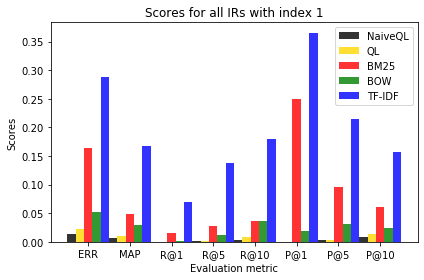

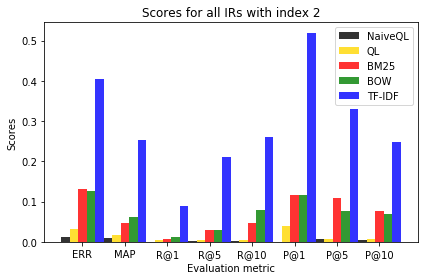

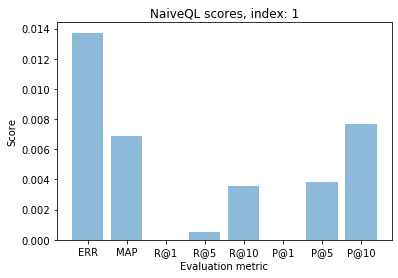

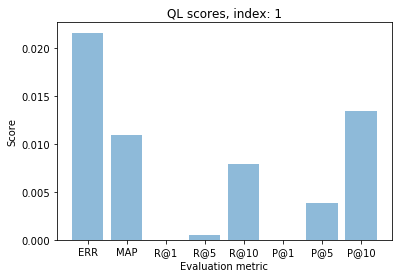

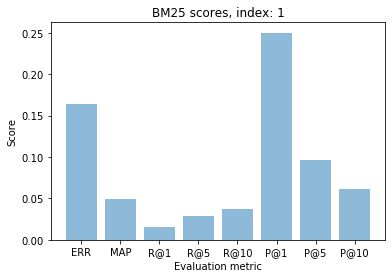

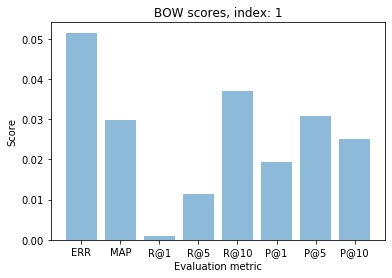

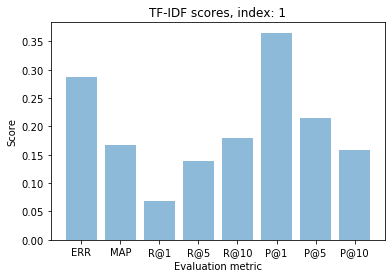

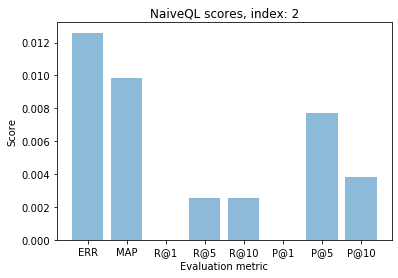

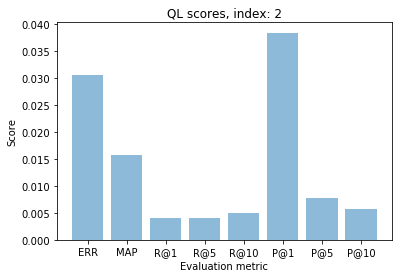

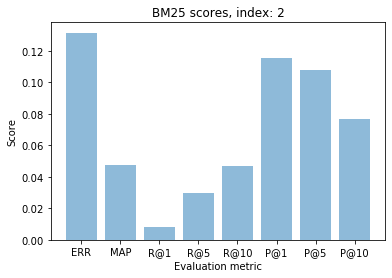

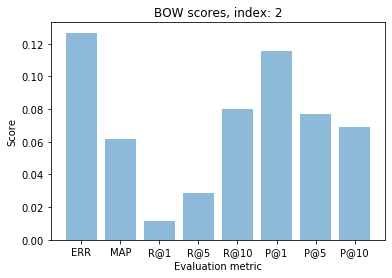

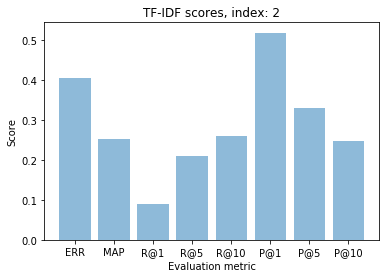

In [98]:
# TODO: Implement this! (20 points)
# Compare index 1 and 2
print('Results index 1')
pprint(results[1])
print('Results index 2')
pprint(results[2])
indices = 2
number_of_evals = 8

fig, ax = plt.subplots()
index = np.arange(number_of_evals)
bar_width = 0.2
opacity = 0.8
colors=['k', 'gold', 'r', 'g', 'b']
g=0
b=0

#total bar chart, i.e. all IRs for all evaluation metrics plotted in the same bar chart for comparison purposes (for both indices)
for i in range(1, indices+1):
    for ir in results[i]:
        eval_values = []
        for eval_met in results[i][ir]:
            y_pos = np.arange(len(results[i][ir]))
            eval_values.append(results[i][ir][eval_met])

        rects = plt.bar(index + b, eval_values, bar_width, alpha=opacity, color=colors[g], label=ir)
        g += 1
        b += bar_width
    g=0
    b=0
    clear_labels = [w.replace('Precision', 'P') for w in results[i][ir]]
    clear_labels = [w.replace('Recall', 'R') for w in clear_labels]
    plt.xlabel('Evaluation metric')
    plt.ylabel('Scores')
    plt.title('Scores for all IRs with index ' + str(i))
    plt.xticks(index + 2*bar_width, clear_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
#individual bar charts, i.e. seperate plots for every information retrieval for more insight (for both indices)
for i in range(1, indices+1):
    for ir in results[i]:
        eval_values = []
        for eval_met in results[i][ir]:
            y_pos = np.arange(len(results[i][ir]))
            eval_values.append(results[i][ir][eval_met])

        clear_labels = [w.replace('Precision', 'P') for w in results[i][ir]]
        clear_labels = [w.replace('Recall', 'R') for w in clear_labels]
        plt.bar(y_pos, eval_values, align='center', alpha=0.5)
        plt.xticks(y_pos, clear_labels)
        plt.xlabel('Evaluation metric')
        plt.ylabel('Score')
        plt.title(ir + ' scores, index: ' + str(i))
        plt.show()    


# Compare different search functions (BOW, TFID, NaiveQL, QL, BM25)
# Compare different evaluation metrics
# Use answers from previous questions

Write a summary of what you observe in the results.
Your summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      
*Hint*: You may build upon the answers from the previous sections. 

## Summary results

**Write something here about graphs**

Now that we have gathered all results and visualized in the plots in the previous section, we can compare the results from the different information retrieval methods and evaluation metrics, as well as differences across the 2 indices. Between the indices we would expect to see better results for index 2 out of the two indices, as stemming and stopword removal are effective methods for improving ranking. We can in fact observe that in the case of index 2 higher overall scores are achieved, primarily by TF-IDF (near 0.5 for Precision@1) and BOW. BM25 has better scores for multiple metrics (e.g. Recall@10, Recall@5, Precision@10) but most noticeably has a lesser score for Precision@1 and Recall@1, which can most likely be attributed to chance as having a cut-off of 1 can introduce results that are based on a too narrow sample size potentially causing exaggerated ranking to words. NaiveQL and QL get slightly better scores as well. Overall, the difference between index 1 and 2 can be attributed to enabling stemming that will make words that have a similar implication classified as the same, leading to generally better results. Removing stopwords will also improve the results and give better scores as irrelevant or 'meaningless' words will not affect the ranking process, resulting in a more defined ranking process. We can see this influence of removing stopwords as well, due to the generally beter results of index 2 versus index 1. When comparing the evaluation metrics we see that ERR has more correlated scores compared to the others, this can be most likely attributed due to the more inclusive nature of ERR where documents that appear after the most relevant documents get a discounted value.